In [232]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split 
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [397]:
col_names =["INSTNM", "MD_EARN_WNE_P10", "AVGFACSAL"]

df = pd.read_csv('Data/MERGED2013_14_PP.csv',
                 usecols=col_names)
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
#"DEBT_MDN", "STABBR", "COSTT4_A", "ADM_RATE", "SAT_AVG", "UGDS",
#df["DEBT_MDN"] = df["DEBT_MDN"].astype(str).astype(float)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)
df

,INSTNM,AVGFACSAL,MD_EARN_WNE_P10
0,Alabama A & M University,7079.0,29900
1,University of Alabama at Birmingham,10170.0,40200
2,Amridge University,3849.0,40100
3,University of Alabama in Huntsville,9341.0,45600
4,Alabama State University,6557.0,26700
...,...,...,...
7437,Georgia Military College-Distance Learning Cam...,3802.0,30500
7438,Brown Mackie College-Dallas,3750.0,29600
7440,Arizona College-Mesa,2289.0,24100
7443,Central Georgia Technical College,4257.0,20600


/Users/taimur/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


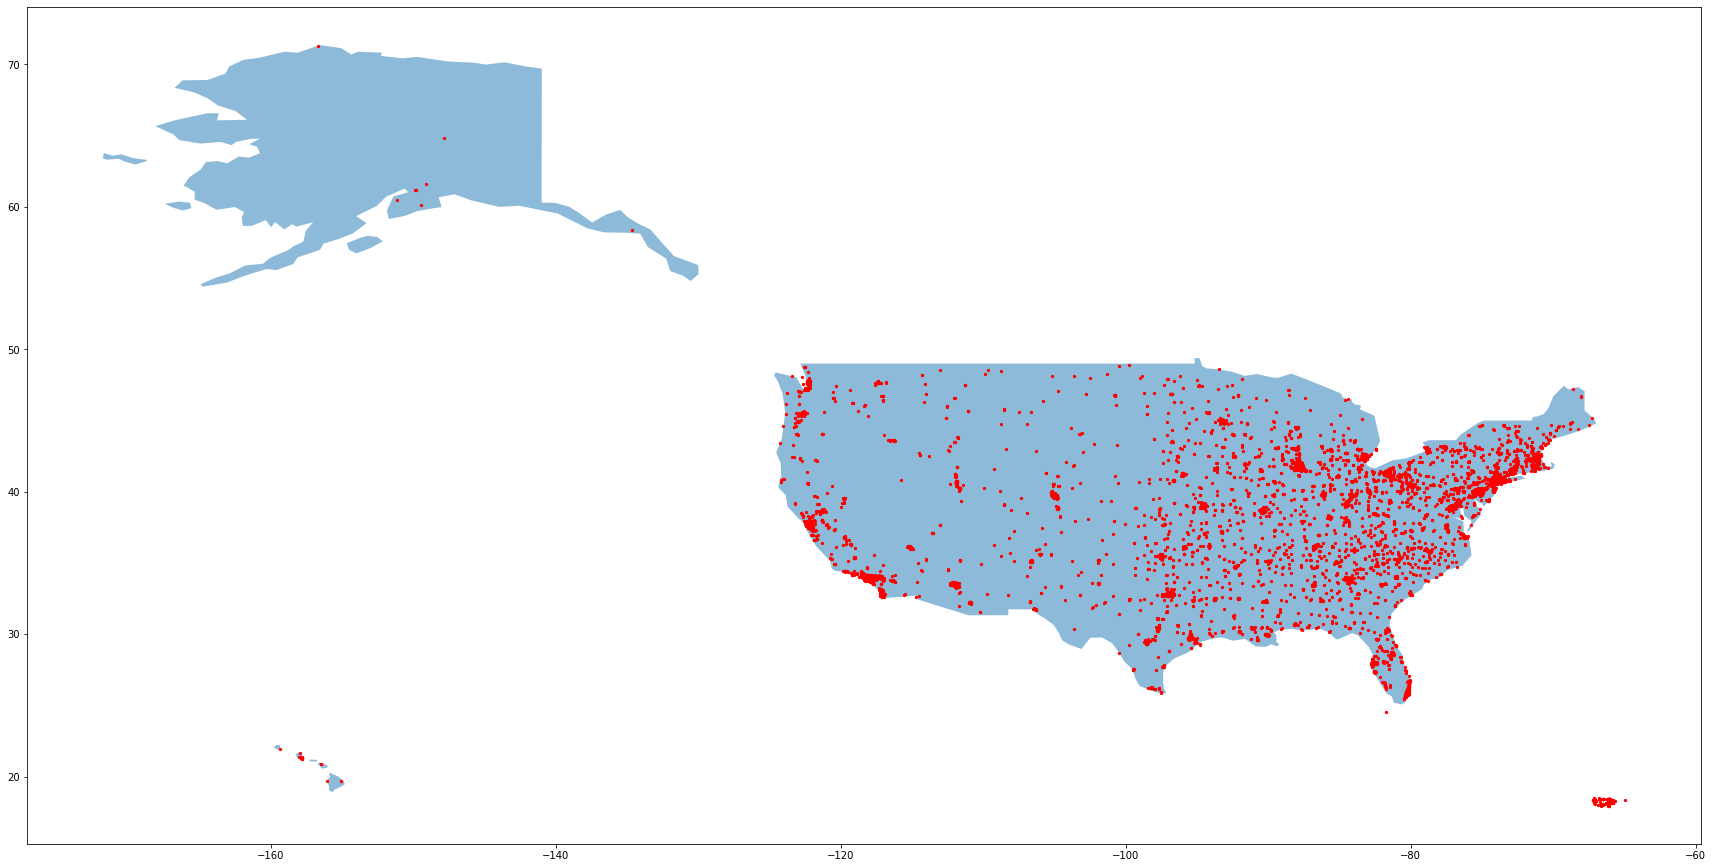

In [122]:
#show schools on us map to give idea of where most schools are
df_lat_long = pd.read_csv('Data/MERGED2018_19_PP.csv',
                 usecols=["LATITUDE", "LONGITUDE"])
df_lat_long.dropna()
crs = {'init': 'epsg:4326'}
street_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
street_map = street_map[(street_map.iso_a3 == 'USA')]
base = street_map.plot(figsize=(30,30), alpha = 0.5)
geometry = [Point(xy) for xy in zip(df_lat_long["LONGITUDE"], df_lat_long["LATITUDE"])]
geo_df = gpd.GeoDataFrame(df_lat_long, crs=crs, geometry=geometry)
geo_df = geo_df[(geo_df["LONGITUDE"] < 0) & (geo_df["LATITUDE"] > 0)]
geo_df.plot(ax = base, markersize = 5, color='red', marker="o")

In [157]:
#show top cost schools
print(df.nlargest(10, columns=['COSTT4_A'])[['INSTNM', 'COSTT4_A']])

#show top salary schools
print(df.nlargest(10, columns=['MD_EARN_WNE_P10'])[['INSTNM', 'MD_EARN_WNE_P10']])

                                           INSTNM  COSTT4_A
4403                             Landmark College   64233.0
2627                       Sarah Lawrence College   62636.0
2158            Washington University in St Louis   62594.0
1037                        University of Chicago   62425.0
2454  Columbia University in the City of New York   61540.0
2245                            Dartmouth College   61398.0
704                           Wesleyan University   61167.0
1138                      Northwestern University   60729.0
456                            Occidental College   60655.0
353                           Harvey Mudd College   60613.0
                                              INSTNM  MD_EARN_WNE_P10
2403  Albany College of Pharmacy and Health Sciences           122600
2141                   St. Louis College of Pharmacy           120400
1736                                MCPHS University           112700
1738           Massachusetts Institute of Technology        

In [159]:
#show top cost schools
print(df.nsmallest(10, columns=['COSTT4_A'])[['INSTNM', 'COSTT4_A']])

#show top salary schools
print(df.nsmallest(10, columns=['MD_EARN_WNE_P10'])[['INSTNM', 'MD_EARN_WNE_P10']])

                                                 INSTNM  COSTT4_A
4301  Instituto Tecnologico de Puerto Rico-Recinto d...    4157.0
4291  Instituto Tecnologico de Puerto Rico-Recinto d...    5025.0
2739                        Cleveland Community College    5111.0
6319              Escuela De Troqueleria Y Herramentaje    5238.0
2036                      Pearl River Community College    5285.0
1080                              Olney Central College    5827.0
983                           Leeward Community College    5931.0
4875                              Lincoln Trail College    6103.0
2008                          Coahoma Community College    6136.0
7099                          Virginia College-Columbus    6172.0
                                            INSTNM  MD_EARN_WNE_P10
4902      Rabbinical College of Ohr Shimon Yisroel            12400
2415                Associated Beth Rivkah Schools            12700
2711                             Yeshivath Viznitz            12800
46

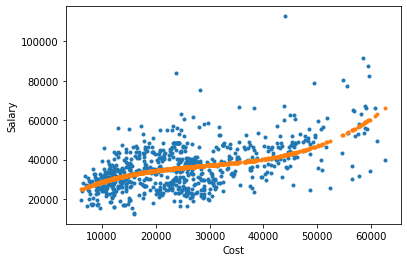

In [306]:
X = df['COSTT4_A'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

poly = PolynomialFeatures(degree=3)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

plt.xlabel('Cost')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [309]:
l1_loss = np.sum(np.abs(y_pred - y_test))
print("l1 loss={:.2e}".format(l1_loss))
print("mean l1 loss={:.2e}".format(l1_loss/len(X_test)))

l1 loss=5.60e+06
mean l1 loss=7.25e+03


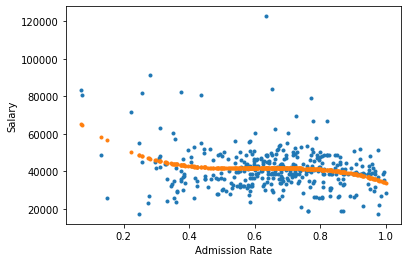

In [324]:
X = df['ADM_RATE'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

poly = PolynomialFeatures(degree=3)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

plt.xlabel('Admission Rate')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [325]:
l1_loss = np.sum(np.abs(y_pred - y_test))
print("l1 loss={:.2e}".format(l1_loss))
print("mean l1 loss={:.2e}".format(l1_loss/len(X_test)))

l1 loss=2.87e+06
mean l1 loss=7.57e+03


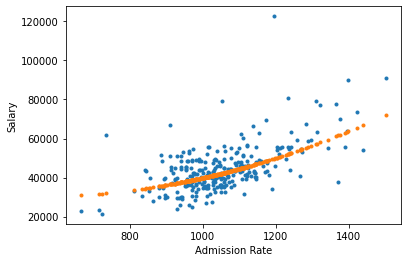

In [336]:
X = df['SAT_AVG'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

poly = PolynomialFeatures(degree=2)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

plt.xlabel('SAT Average')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [337]:
l1_loss = np.sum(np.abs(y_pred - y_test))
print("l1 loss={:.2e}".format(l1_loss))
print("mean l1 loss={:.2e}".format(l1_loss/len(X_test)))

l1 loss=1.83e+06
mean l1 loss=6.57e+03


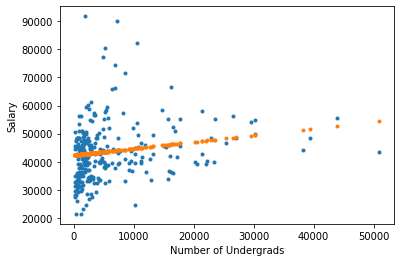

In [358]:
X = df['UGDS'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

plt.xlabel('Number of Undergrads')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [348]:
l1_loss = np.sum(np.abs(y_pred - y_test))
print("l1 loss={:.2e}".format(l1_loss))
print("mean l1 loss={:.2e}".format(l1_loss/len(X_test)))

l1 loss=1.39e+06
mean l1 loss=4.99e+03


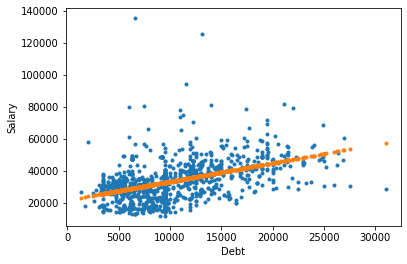

In [391]:
X = df['DEBT_MDN'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

plt.xlabel('Debt')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [392]:
l1_loss = np.sum(np.abs(y_pred - y_test))
print("l1 loss={:.2e}".format(l1_loss))
print("mean l1 loss={:.2e}".format(l1_loss/len(X_test)))

l1 loss=9.49e+06
mean l1 loss=8.29e+03


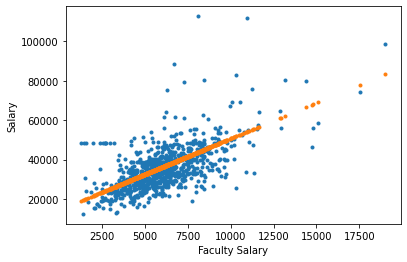

In [417]:
X = df['AVGFACSAL'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

plt.xlabel('Faculty Salary')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [418]:
#baseline
median_salary = np.median(y_test)
ytest_pred_loss_arr = np.abs(y_test - median_salary)
baseline_test_loss = np.sum(ytest_pred_loss_arr)
print("mean basline test loss using median="+"{:.2e}".format(baseline_test_loss/len(X_test)))

l1_loss = np.sum(np.abs(y_pred - y_test))
print("l1 loss={:.2e}".format(l1_loss))
print("mean l1 loss={:.2e}".format(l1_loss/len(X_test)))

mean basline test loss using median=8.28e+03
l1 loss=5.30e+06
mean l1 loss=6.39e+03
